Approach 3 – Large GRU

Lookback window: 90 time steps

Layers: 3

Units: 128 units

Dropout: 0.3

Optimizer: Adam (learning rate = 0.0005)

Loss: MSE

Batch size: 16

Epochs: up to 200

In [ ]:
# ====================== Imports & Reproducibility ======================
import os, math, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras import layers, Model
from IPython.display import display

np.random.seed(42)
tf.random.set_seed(42)
print("TensorFlow:", tf.__version__)

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

TensorFlow: 2.19.0


In [ ]:
# ====================== Config ======================
CSV_PATH    = "../dataset/TSLA.csv"   # update if needed
DATE_COL    = "Date"
CLOSE_COL   = "Close"
TRAIN_START = "2015-01-12"

# Approach 1-like config but for GRU
LOOKBACK    = 90      # shorter history
EPOCHS      = 200     # max epochs
BATCH_SIZE  = 16      # batch size

GRU_UNITS   = 128     # smaller model
GRU_LAYERS  = 3       # single GRU layer
GRU_DROPOUT = 0.3     # dropout

# Splits (chronological): 80% / 10% / 10%
TRAIN_RATIO = 0.80
VAL_RATIO   = 0.10
TEST_RATIO  = 0.10

In [ ]:
CSV_PATH = "/content/TSLA.csv" # Update this path after uploading the file
import os
print(os.path.exists(CSV_PATH))

True


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-12,13.536667,13.631333,13.283333,13.480667,13.480667,89254500
2015-01-13,13.554667,13.840667,13.394000,13.616667,13.616667,67159500
2015-01-14,12.388667,13.013333,12.333333,12.846000,12.846000,173278500


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-06-11,173.919998,174.750000,167.410004,170.660004,170.660004,64761900
2024-06-12,171.119995,180.550003,169.800003,177.289993,177.289993,89884800
2024-06-13,188.427994,191.050003,181.940094,184.434998,184.434998,97297153


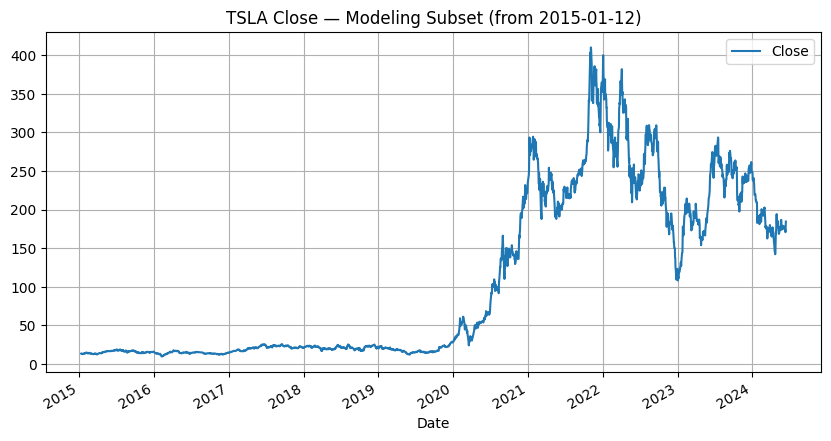

In [ ]:
# ====================== Load, clean, plot ======================
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"CSV not found at {CSV_PATH}. Update CSV_PATH.")

df = pd.read_csv(CSV_PATH)
if DATE_COL not in df.columns or CLOSE_COL not in df.columns:
    raise ValueError(
        f"Expected '{DATE_COL}' and '{CLOSE_COL}' in columns: {df.columns.tolist()}"
    )

df[DATE_COL] = pd.to_datetime(df[DATE_COL])
df = df.sort_values(DATE_COL).reset_index(drop=True).set_index(DATE_COL)
# Restrict to modeling start date
df = df[df.index >= TRAIN_START].copy()

# Fill missing closes
if df[CLOSE_COL].isna().any():
    df[CLOSE_COL] = (
        df[CLOSE_COL]
        .interpolate(method="time")
        .fillna(method="bfill")
        .fillna(method="ffill")
    )

display(df.head(3))
display(df.tail(3))

df[[CLOSE_COL]].plot(title=f"TSLA Close — Modeling Subset (from {TRAIN_START})")
plt.show()

In [ ]:
# ====================== Chronological 80/10/10 split (no leakage) ======================
close_values = df[[CLOSE_COL]].values.astype("float32")
n = len(close_values)
n_train = int(np.floor(TRAIN_RATIO * n))
n_val   = int(np.floor(VAL_RATIO   * n))
n_test  = n - n_train - n_val
assert n_train > LOOKBACK and n_val > 0 and n_test > 0, "Not enough data for chosen LOOKBACK/splits."

train_raw = close_values[:n_train]
val_raw   = close_values[n_train:n_train+n_val]
test_raw  = close_values[n_train+n_val:]

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train_raw)  # fit on train only
train_scaled = scaler.transform(train_raw)
val_scaled   = scaler.transform(val_raw)
test_scaled  = scaler.transform(test_raw)

print(f"Total: {n} | Train: {n_train} | Val: {n_val} | Test: {n_test}")

Total: 2372 | Train: 1897 | Val: 237 | Test: 238


In [ ]:
# ====================== Windowing util ======================
def make_xy(series_2d, lookback=60):
    """series_2d: shape (N, 1). Returns X: (samples, lookback, 1), y: (samples,)"""
    X, y = [], []
    for i in range(lookback, len(series_2d)):
        X.append(series_2d[i - lookback:i, 0])
        y.append(series_2d[i, 0])
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    return X.reshape((X.shape[0], X.shape[1], 1)), y

# Train windows come purely from train
X_train, y_train = make_xy(train_scaled, LOOKBACK)

# Validation windows need LOOKBACK context from the end of train
val_with_ctx = np.concatenate([train_scaled[-LOOKBACK:], val_scaled], axis=0)
X_val, y_val = make_xy(val_with_ctx, LOOKBACK)  # -> exactly len(val_scaled) samples

# Test windows need LOOKBACK context from the end of val
test_with_ctx = np.concatenate([val_scaled[-LOOKBACK:], test_scaled], axis=0)
X_test, y_test = make_xy(test_with_ctx, LOOKBACK)  # -> exactly len(test_scaled) samples

print("Shapes:",
      "\n  X_train", X_train.shape, "y_train", y_train.shape,
      "\n  X_val  ", X_val.shape,   "y_val  ", y_val.shape,
      "\n  X_test ", X_test.shape,  "y_test ", y_test.shape)

Shapes: 
  X_train (1807, 90, 1) y_train (1807,) 
  X_val   (237, 90, 1) y_val   (237,) 
  X_test  (238, 90, 1) y_test  (238,)


In [ ]:
# ====================== GRU model (instead of LSTM) ======================
def build_gru(lookback=90, gru_units=128, num_layers=3, dropout=0.3):
    """
    Simple stacked GRU regressor:
      Input:  (lookback, 1)
      Output: scalar next-step prediction
    """
    inp = layers.Input(shape=(lookback, 1))
    x = inp

    # First (num_layers - 1) GRU layers with return_sequences=True
    for i in range(max(0, num_layers - 1)):
        x = layers.GRU(gru_units, return_sequences=True)(x)
        x = layers.Dropout(dropout)(x)

    # Last GRU layer without return_sequences
    x = layers.GRU(gru_units, return_sequences=False)(x)
    x = layers.Dropout(dropout)(x)

    out = layers.Dense(1)(x)

    model = Model(inp, out)
    model.compile(optimizer="adam", loss="mse")
    return model

In [ ]:
# ====================== Timing & per-epoch Test evaluation ======================
class TimeAndTestCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_test, y_test):
        super().__init__()
        self.X_test, self.y_test = X_test, y_test
        self.cum_times = []
        self.train_losses = []
        self.val_losses = []
        self.test_losses = []
        self._t0 = None

    def on_train_begin(self, logs=None):
        self._t0 = time.perf_counter()

    def on_epoch_end(self, epoch, logs=None):
        t_now = time.perf_counter()
        self.cum_times.append(t_now - self._t0)
        self.train_losses.append(float(logs.get("loss", np.nan)))
        self.val_losses.append(float(logs.get("val_loss", np.nan)))
        test_loss = self.model.evaluate(self.X_test, self.y_test, verbose=0)
        self.test_losses.append(float(test_loss))

    # This method was incorrectly nested inside on_epoch_end. Correcting its indentation.
    def to_frame(self):
        df_log = pd.DataFrame({
            "epoch": np.arange(1, len(self.cum_times) + 1),
            "time_sec_cum": self.cum_times,
            "train_loss": self.train_losses,
            "val_loss": self.val_losses,
            "test_loss": self.test_losses
        })
        df_log["train_rmse"] = np.sqrt(df_log["train_loss"])
        df_log["test_rmse"]  = np.sqrt(df_log["test_loss"])
        return df_log


def timed_fit(model, X_train, y_train, X_val, y_val, X_test, y_test,
              epochs=EPOCHS, batch_size=BATCH_SIZE):
    tcb = TimeAndTestCallback(X_test, y_test)
    es  = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )
    hist = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs, batch_size=batch_size,
        verbose=1, shuffle=False,
        callbacks=[tcb, es]
    )
    return hist, tcb.to_frame()

In [ ]:
# ====================== Train GRU ONCE (timed) ======================
gru_model = build_gru(
    lookback=LOOKBACK,
    gru_units=GRU_UNITS,
    num_layers=GRU_LAYERS,
    dropout=GRU_DROPOUT
)
print(gru_model.summary())

_, log_df_gru = timed_fit(
    gru_model, X_train, y_train, X_val, y_val, X_test, y_test,
    epochs=EPOCHS, batch_size=BATCH_SIZE
)

display(log_df_gru.head())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 90, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 90, 128)        │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 90, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 90, 128)        │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 90, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 128)            │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 248,577 (971.00 KB)

 Trainable params: 248,577 (971.00 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 34s 238ms/step - loss: 9.6033e-04 - val_loss: 0.0072
Epoch 2/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 27s 239ms/step - loss: 0.0129 - val_loss: 0.0130
Epoch 3/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 238ms/step - loss: 0.0279 - val_loss: 0.0083
Epoch 4/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 28s 246ms/step - loss: 0.0191 - val_loss: 0.0108
Epoch 5/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 246ms/step - loss: 0.0223 - val_loss: 0.0099
Epoch 6/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 27s 238ms/step - loss: 0.0233 - val_loss: 0.0106
Epoch 7/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 27s 239ms/step - loss: 0.0242 - val_loss: 0.0078
Epoch 8/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 235ms/step - loss: 0.0201 - val_loss: 0.0050
Epoch 9/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 27s 236ms/step - loss: 0.0141 - val_loss: 0.0058
Epoch 10/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 27s 241ms/step - loss: 0.0143 - val_loss: 0.0022
Epoch 11/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 27s 240ms/step - loss: 0.0082 - val_loss: 0.0024

,epoch,time_sec_cum,train_loss,val_loss,test_loss,train_rmse,test_rmse
0,1,33.217889,0.004489,0.007245,0.003514,0.067002,0.059281
1,2,60.204862,0.013263,0.012975,0.006618,0.115166,0.081352
2,3,101.011916,0.017804,0.008283,0.004297,0.133433,0.065548
3,4,128.404051,0.016158,0.010754,0.005745,0.127114,0.075796
4,5,169.789429,0.014274,0.009860,0.004703,0.119473,0.068578


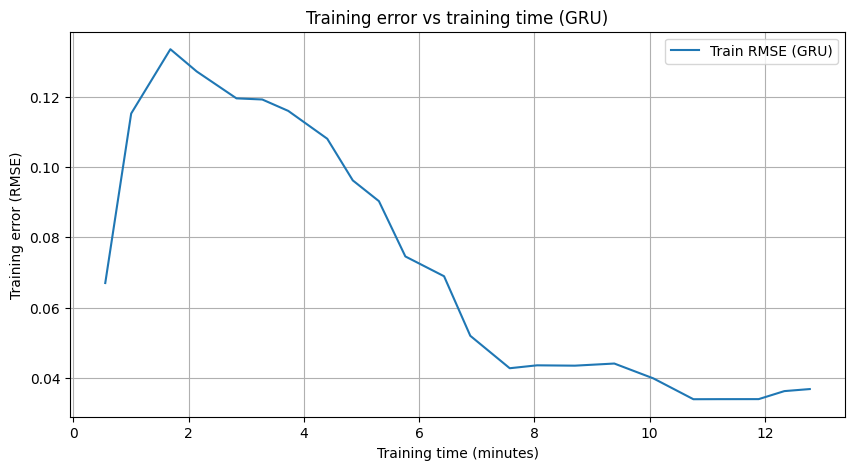

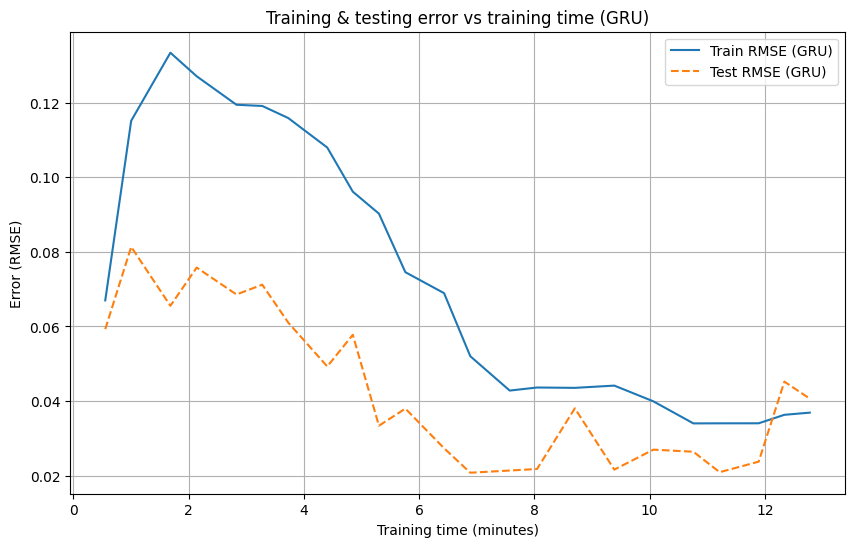

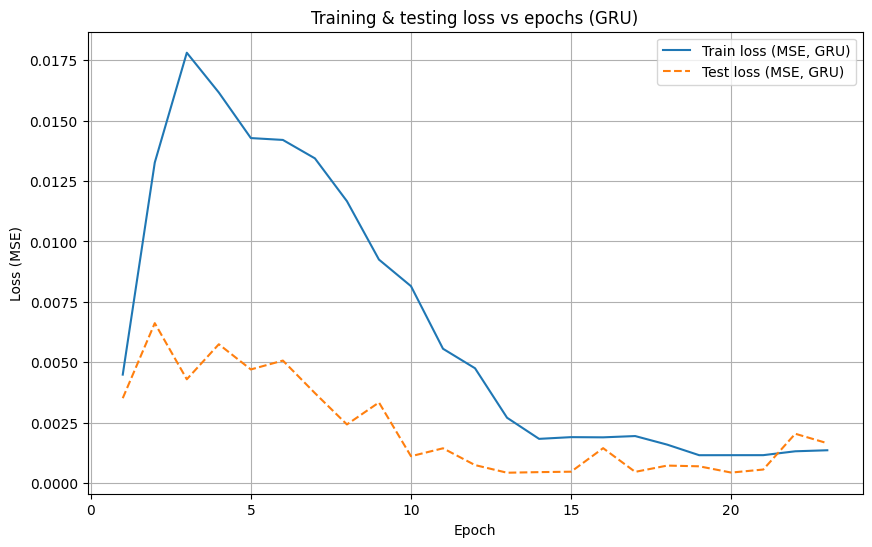

In [ ]:
# ====================== Required Plots (GRU) ======================
# 1) Training error vs training time
plt.figure(figsize=(10,5))
plt.plot(log_df_gru["time_sec_cum"]/60.0, log_df_gru["train_rmse"], label="Train RMSE (GRU)")
plt.xlabel("Training time (minutes)")
plt.ylabel("Training error (RMSE)")
plt.title("Training error vs training time (GRU)")
plt.legend()
plt.grid(True)
plt.show()

# 2) Training & testing error vs training time
plt.figure(figsize=(10,6))
plt.plot(log_df_gru["time_sec_cum"]/60.0, log_df_gru["train_rmse"], label="Train RMSE (GRU)")
plt.plot(log_df_gru["time_sec_cum"]/60.0, log_df_gru["test_rmse"],  linestyle="--", label="Test RMSE (GRU)")
plt.xlabel("Training time (minutes)")
plt.ylabel("Error (RMSE)")
plt.title("Training & testing error vs training time (GRU)")
plt.legend()
plt.grid(True)
plt.show()

# 3) Loss (training & testing) vs epochs
plt.figure(figsize=(10,6))
plt.plot(log_df_gru["epoch"], log_df_gru["train_loss"], label="Train loss (MSE, GRU)")
plt.plot(log_df_gru["epoch"], log_df_gru["test_loss"],  linestyle="--", label="Test loss (MSE, GRU)")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training & testing loss vs epochs (GRU)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# ====================== TEST endpoint predictions & metrics for H in {1,7,15} ======================
def rmse(a, b):
    return math.sqrt(mean_squared_error(a, b))

def collect_metrics(name, y_true, y_pred):
    return {
        "Model": name,
        "RMSE": rmse(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2":  r2_score(y_true, y_pred),
    }


def endpoint_results_for_H(model, H, use_val_context=True, model_name_prefix="GRU"):
    """
    Build Actual vs Predicted (endpoint-only) for TEST at horizon H.
    use_val_context=True -> test windows may use LOOKBACK context from validation (matches X_test construction).
    """
    scaled_full = scaler.transform(close_values).ravel()
    start_test = n_train + n_val
    n_total = len(scaled_full)
# start index policy
    if use_val_context:
        start_t = max(start_test, LOOKBACK)              # allow context from val
    else:
        start_t = max(start_test + LOOKBACK, LOOKBACK)   # force window fully inside test

    end_t = n_total - H
    dates, true_end, pred_end = [], [], []

    for t in range(start_t, end_t):
        window = scaled_full[t-LOOKBACK:t]
        w = window.reshape(1, LOOKBACK, 1).copy()

        # recursive k-step to reach the H-th step
        p = None
        for _ in range(H):
            p = model.predict(w, verbose=0)[0, 0]
            w = np.concatenate([w[:, 1:, :], np.array(p).reshape(1, 1, 1)], axis=1)

        pred_end.append(p)
        true_end.append(scaled_full[t + H - 1])
        dates.append(df.index[t + H - 1])

    inv_true = scaler.inverse_transform(np.array(true_end).reshape(-1,1)).ravel()
    inv_pred = scaler.inverse_transform(np.array(pred_end).reshape(-1,1)).ravel()

    col_name = f"{model_name_prefix}(H={H})"
    results = pd.DataFrame(
        {"Actual": inv_true, col_name: inv_pred},
        index=pd.DatetimeIndex(dates, name="Date"),
    )
    m = collect_metrics(col_name, results["Actual"], results[col_name])
    print(f"Test metrics (H={H}): {m}")
    return results, m


# Run for H = 1, 7, 15 on TEST
results_1_gru,  metrics_1_gru  = endpoint_results_for_H(gru_model, H=1,  use_val_context=True, model_name_prefix="GRU")
display(results_1_gru.head())

results_7_gru,  metrics_7_gru  = endpoint_results_for_H(gru_model, H=7,  use_val_context=True, model_name_prefix="GRU")
display(results_7_gru.head())

results_15_gru, metrics_15_gru = endpoint_results_for_H(gru_model, H=15, use_val_context=True, model_name_prefix="GRU")
display(results_15_gru.head())

# Optional summary table
summary_test_gru = pd.DataFrame([metrics_1_gru, metrics_7_gru, metrics_15_gru])[["Model","RMSE","MSE","MAE","R2"]]
display(
    summary_test_gru
        .style.format({"RMSE":"{:.4f}","MSE":"{:.4f}","MAE":"{:.4f}","R2":"{:.4f}"})
        .set_caption("TEST metrics by horizon (GRU)")
)


Test metrics (H=1): {'Model': 'GRU(H=1)', 'RMSE': 8.325413360872512, 'MSE': 69.31250762939453, 'MAE': 6.448373317718506, 'R2': 0.9491276741027832}


,Actual,GRU(H=1)
Date,,
2023-07-06,276.540009,277.218414
2023-07-07,274.429993,278.282776
2023-07-10,269.609985,276.539703
2023-07-11,269.790009,272.935242
2023-07-12,271.989990,270.737762


Test metrics (H=7): {'Model': 'GRU(H=7)', 'RMSE': 20.692071784062534, 'MSE': 428.1618347167969, 'MAE': 17.29170799255371, 'R2': 0.6739885807037354}


,Actual,GRU(H=7)
Date,,
2023-07-14,281.380005,278.671326
2023-07-17,290.380005,278.138947
2023-07-18,293.339996,275.647125
2023-07-19,291.260010,271.309662
2023-07-20,262.899994,269.265717


Test metrics (H=15): {'Model': 'GRU(H=15)', 'RMSE': 30.55246212491771, 'MSE': 933.4529418945312, 'MAE': 26.186935424804688, 'R2': 0.2323552966117859}


,Actual,GRU(H=15)
Date,,
2023-07-26,264.350006,277.726807
2023-07-27,255.710007,277.149719
2023-07-28,266.440002,274.507111
2023-07-31,267.429993,269.988861
2023-08-01,261.070007,267.899994


,Model,RMSE,MSE,MAE,R2
0,GRU(H=1),8.3254,69.3125,6.4484,0.9491
1,GRU(H=7),20.6921,428.1618,17.2917,0.6740
2,GRU(H=15),30.5525,933.4529,26.1869,0.2324


In [ ]:
 #====================== TRAIN endpoint metrics for H in {1,7,15} ======================
def endpoint_train_results_for_H(model, H, model_name_prefix="GRU"):
    """
    Build Actual vs Predicted (endpoint-only) for TRAIN at horizon H.
    Uses only the train region (no val/test in the input window).
    """
    scaled_full = scaler.transform(close_values).ravel()

    dates, true_end, pred_end = [], [], []

    # windows and endpoints must stay inside [0, n_train)
    start_t = LOOKBACK          # need LOOKBACK history
    end_t   = n_train - H       # keep H-th step inside train

    for t in range(start_t, end_t):
        window = scaled_full[t-LOOKBACK:t]
        w = window.reshape(1, LOOKBACK, 1).copy()

        # recursive k-step to reach the H-th step
        p = None
        for _ in range(H):
            p = model.predict(w, verbose=0)[0, 0]
            w = np.concatenate([w[:, 1:, :], np.array(p).reshape(1, 1, 1)], axis=1)

        pred_end.append(p)
        true_end.append(scaled_full[t + H - 1])
        dates.append(df.index[t + H - 1])

    inv_true = scaler.inverse_transform(np.array(true_end).reshape(-1, 1)).ravel()
    inv_pred = scaler.inverse_transform(np.array(pred_end).reshape(-1, 1)).ravel()

    col_name = f"{model_name_prefix}(H={H})"
    results = pd.DataFrame(
        {"Actual": inv_true, col_name: inv_pred},
        index=pd.DatetimeIndex(dates, name="Date"),
    )

    m = collect_metrics(col_name, results["Actual"], results[col_name])
    print(f"Train metrics (H={H}): {m}")
    return results, m


# TRAIN metrics by horizon
train_res_1_gru,  train_metrics_1_gru  = endpoint_train_results_for_H(gru_model, H=1,  model_name_prefix="GRU")
train_res_7_gru,  train_metrics_7_gru  = endpoint_train_results_for_H(gru_model, H=7,  model_name_prefix="GRU")
train_res_15_gru, train_metrics_15_gru = endpoint_train_results_for_H(gru_model, H=15, model_name_prefix="GRU")

summary_train_gru = pd.DataFrame(
    [train_metrics_1_gru, train_metrics_7_gru, train_metrics_15_gru]
)[["Model", "RMSE", "MSE", "MAE", "R2"]]

display(
    summary_train_gru
        .style.format({"RMSE": "{:.4f}", "MSE": "{:.4f}", "MAE": "{:.4f}", "R2": "{:.4f}"})
        .set_caption("TRAIN metrics by horizon (GRU)")
)


Train metrics (H=1): {'Model': 'GRU(H=1)', 'RMSE': 32.505436369239646, 'MSE': 1056.6033935546875, 'MAE': 29.51080894470215, 'R2': 0.9065881371498108}
Train metrics (H=7): {'Model': 'GRU(H=7)', 'RMSE': 93.95927683376985, 'MSE': 8828.345703125, 'MAE': 85.14318084716797, 'R2': 0.22106623649597168}
Train metrics (H=15): {'Model': 'GRU(H=15)', 'RMSE': 134.481665513835, 'MSE': 18085.318359375, 'MAE': 122.6082763671875, 'R2': -0.5914214849472046}


,Model,RMSE,MSE,MAE,R2
0,GRU(H=1),32.5054,1056.6034,29.5108,0.9066
1,GRU(H=7),93.9593,8828.3457,85.1432,0.2211
2,GRU(H=15),134.4817,18085.3184,122.6083,-0.5914
